# Project: Pre-process data to improve the prediction of house sales' prices

**[Co-authored]**

---

Aim of the project:
- Improve the prediction of a Sale Price boundary in house sales, using feature engineering across 6 iterations to improve the algorithm
- Use different strategies to handle data features, in order to increase their utility for the given task: handling/encoding missing value, encoding categorical data, feature scaling and feature selection.

---

## Setup

In [1]:
from pgds_mpp_utils import train_and_evaluation
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from projHousePrices_utils import (
    AdditionalFeature,
    compute_pca,
    get_ohe_dataframe,
    get_dataframe_scaled,
    get_series_scaled_dataframe,
    get_dataframe_zscore,
    get_series_zscore_dataframe
)

---

# Loading, describing and transforming data

In [2]:
df_houses_raw = pd.read_csv('houses.csv')

In [3]:
df_houses_raw.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


1.2- Print dataset total number of `observations` and `variables`

In [4]:
df_houses_raw.shape

(1460, 81)

---

### Considered columns

In [5]:
columns_list = ['FullBath',
                'TotRmsAbvGrd',
                'Fireplaces',
                'GarageYrBlt',
                'GarageCars',
                'GarageArea',
                'LotFrontage',
                'WoodDeckSF',
                'OpenPorchSF',
                'SaleType',
                'SaleCondition',
                'SalePrice']

In [6]:
df_houses = df_houses_raw[columns_list]
df_houses.head(1)

,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,LotFrontage,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice
0,2,8,0,2003.0,2,548,65.0,0,61,WD,Normal,208500


## Target Variable - Sale Price Boundary

The feature `target` is based on `SalePrice`. Binary target, split as:
- `Min->Median` bucket should have assigned the value `0`;
- the other bucket (`Median->Max`) value should be `1`.

In [7]:
sale_price_median = df_houses.SalePrice.median()
sale_price_median

163000.0

In [8]:
df_houses['target'] = 0
df_houses.loc[df_houses.SalePrice > sale_price_median, 'target'] = 1
df_houses.head()

<ipython-input-8-2e0b01ca332a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_houses['target'] = 0
C:\Users\nuno.pinheiro\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,LotFrontage,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice,target
0,2,8,0,2003.0,2,548,65.0,0,61,WD,Normal,208500,1
1,2,6,1,1976.0,2,460,80.0,298,0,WD,Normal,181500,1
2,2,6,1,2001.0,2,608,68.0,0,42,WD,Normal,223500,1
3,1,7,1,1998.0,3,642,60.0,0,35,WD,Abnorml,140000,0
4,2,9,1,2000.0,3,836,84.0,192,84,WD,Normal,250000,1


## Missing Values

Amount of missing values per column

In [9]:
missing_count = df_houses.isna().sum()
missing_count

FullBath           0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
LotFrontage      259
WoodDeckSF         0
OpenPorchSF        0
SaleType           0
SaleCondition      0
SalePrice          0
target             0
dtype: int64

In [10]:
elements_number = df_houses.shape[0]
missing_percentage = missing_count/elements_number*100
missing_percentage

FullBath          0.000000
TotRmsAbvGrd      0.000000
Fireplaces        0.000000
GarageYrBlt       5.547945
GarageCars        0.000000
GarageArea        0.000000
LotFrontage      17.739726
WoodDeckSF        0.000000
OpenPorchSF       0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
target            0.000000
dtype: float64

Process the missing values in the column `LotFrontage`

In [11]:
lotfrontage_value_counts = df_houses.LotFrontage.value_counts(dropna=False)
lotfrontage_value_counts

NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 111, dtype: int64

In [12]:
lotfrontage_value_percentage = lotfrontage_value_counts/elements_number*100
lotfrontage_value_percentage

NaN      17.739726
60.0      9.794521
70.0      4.794521
80.0      4.726027
50.0      3.904110
           ...    
106.0     0.068493
38.0      0.068493
138.0     0.068493
140.0     0.068493
137.0     0.068493
Name: LotFrontage, Length: 111, dtype: float64

In [13]:
df_houses.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

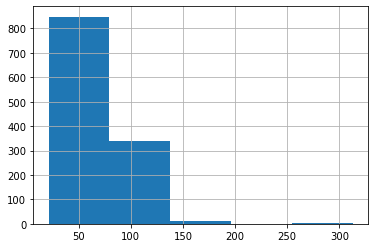

In [14]:
df_houses.LotFrontage.hist(bins=5)

In [15]:
# MISSING_VALUE_TOKEN different from all the other values, as seen with "df_houses.LotFrontage.describe()"
MISSING_VALUE_TOKEN = -1

df_houses['LotFrontage_encoded'] = df_houses.LotFrontage.fillna(value=MISSING_VALUE_TOKEN)
df_houses.LotFrontage_encoded.value_counts(dropna=False)

<ipython-input-15-2b9025ba5661>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_houses['LotFrontage_encoded'] = df_houses.LotFrontage.fillna(value=MISSING_VALUE_TOKEN)


-1.0      259
 60.0     143
 70.0      70
 80.0      69
 50.0      57
         ... 
 106.0      1
 38.0       1
 138.0      1
 140.0      1
 137.0      1
Name: LotFrontage_encoded, Length: 111, dtype: int64

In [16]:
df_houses['LotFrontage_is_nan'] = False
df_houses.loc[df_houses.LotFrontage_encoded == MISSING_VALUE_TOKEN, 'LotFrontage_is_nan'] = True
df_houses.LotFrontage_is_nan.value_counts()

<ipython-input-16-eb25fab421ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_houses['LotFrontage_is_nan'] = False
C:\Users\nuno.pinheiro\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


False    1201
True      259
Name: LotFrontage_is_nan, dtype: int64

In [17]:
df_houses.loc[df_houses.LotFrontage_encoded == MISSING_VALUE_TOKEN, :].head(3)

,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,LotFrontage,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice,target,LotFrontage_encoded,LotFrontage_is_nan
7,2,7,2,1973.0,2,484,NaN,235,204,WD,Normal,200000,1,-1.0,True
12,1,4,0,1962.0,1,352,NaN,140,0,WD,Normal,144000,0,-1.0,True
14,1,5,1,1960.0,1,352,NaN,0,213,WD,Normal,157000,0,-1.0,True


In [18]:
df_houses.loc[df_houses.LotFrontage_encoded != MISSING_VALUE_TOKEN, :].head(3)

,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,LotFrontage,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice,target,LotFrontage_encoded,LotFrontage_is_nan
0,2,8,0,2003.0,2,548,65.0,0,61,WD,Normal,208500,1,65.0,False
1,2,6,1,1976.0,2,460,80.0,298,0,WD,Normal,181500,1,80.0,False
2,2,6,1,2001.0,2,608,68.0,0,42,WD,Normal,223500,1,68.0,False


## Categorical Data

Creating a `df_categorical` dataframe with the categorical features

In [19]:
df_houses.describe()

,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,LotFrontage,WoodDeckSF,OpenPorchSF,SalePrice,target,LotFrontage_encoded
count,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1.565068,6.517808,0.613014,1978.506164,1.767123,472.980137,70.049958,94.244521,46.660274,180921.195890,0.498630,57.445890
std,0.550916,1.625393,0.644666,24.689725,0.747315,213.804841,24.284752,125.338794,66.256028,79442.502883,0.500169,34.960241
min,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,21.000000,0.000000,0.000000,34900.000000,0.000000,-1.000000
25%,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,59.000000,0.000000,0.000000,129975.000000,0.000000,42.000000
50%,2.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,69.000000,0.000000,25.000000,163000.000000,0.000000,63.000000
75%,2.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,80.000000,168.000000,68.000000,214000.000000,1.000000,79.000000
max,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,313.000000,857.000000,547.000000,755000.000000,1.000000,313.000000


In [20]:
df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FullBath             1460 non-null   int64  
 1   TotRmsAbvGrd         1460 non-null   int64  
 2   Fireplaces           1460 non-null   int64  
 3   GarageYrBlt          1379 non-null   float64
 4   GarageCars           1460 non-null   int64  
 5   GarageArea           1460 non-null   int64  
 6   LotFrontage          1201 non-null   float64
 7   WoodDeckSF           1460 non-null   int64  
 8   OpenPorchSF          1460 non-null   int64  
 9   SaleType             1460 non-null   object 
 10  SaleCondition        1460 non-null   object 
 11  SalePrice            1460 non-null   int64  
 12  target               1460 non-null   int64  
 13  LotFrontage_encoded  1460 non-null   float64
 14  LotFrontage_is_nan   1460 non-null   bool   
dtypes: bool(1), float64(3), int64(9), obje

In [21]:
sale_type_cat = df_houses.SaleType.astype('category')
sale_type_cat.dtype

CategoricalDtype(categories=['COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth',
                  'WD'],
                 ordered=False)

In [22]:
sale_condition_cat = df_houses.SaleCondition.astype('category')
sale_condition_cat.dtype

CategoricalDtype(categories=['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal',
                  'Partial'],
                 ordered=False)

In [23]:
df_categorical = pd.concat([sale_type_cat.to_frame(), sale_condition_cat.to_frame()], axis=1)
df_categorical.head()

,SaleType,SaleCondition
0,WD,Normal
1,WD,Normal
2,WD,Normal
3,WD,Abnorml
4,WD,Normal


#### Apply OHE to `SaleType`

In [24]:
df_sale_type_ohe = get_ohe_dataframe(df_categorical.SaleType, 'SaleType_')

In [25]:
df_sale_type_ohe.head(3)

,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1


## Feature Scaling

#### Scaling `GarageArea` to [-1/3; 3]

In [26]:
garage_area_scaled = get_series_scaled_dataframe(df_houses.GarageArea, 'GarageArea_scaled', (-1/3), 3)
garage_area_scaled.describe()

,GarageArea_scaled
count,1460.000000
mean,0.778515
std,0.502597
min,-0.333333
25%,0.452985
50%,0.795016
75%,1.020686
max,3.000000


# Feature Engineering to predict Sale Price boundaries (target variable)

Remark:
* Use 3 mandatory features
* Use more 3 optional features
* Improve the algorithms performance with feature engineering

### A. Target variable

In [27]:
target_saleprice = df_houses.target

### B. Mandatory features

#### B.1. Categorical Data - 'MasVnrType'

In [28]:
# 'MasVnrType' is categorical, so, it must be processed as such
masvnrtype_cat = df_houses_raw.MasVnrType.astype('category')
masvnrtype_cat.dtype

CategoricalDtype(categories=['BrkCmn', 'BrkFace', 'None', 'Stone'], ordered=False)

In [29]:
masvnrtype_cat_ohe = get_ohe_dataframe(masvnrtype_cat, 'MasVnrType_')
masvnrtype_cat_ohe.head(1)

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
0,0,1,0,0


#### B.2 Missing Values - 'LotFrontage'

In [30]:
pd.concat([df_houses_raw.YearBuilt, df_houses_raw.LotFrontage, masvnrtype_cat_ohe], axis=1).isnull().sum()

YearBuilt               0
LotFrontage           259
MasVnrType_BrkCmn       0
MasVnrType_BrkFace      0
MasVnrType_None         0
MasVnrType_Stone        0
dtype: int64

In [31]:
lotfrontage_missing_encoded = pd.concat([df_houses.LotFrontage_encoded, df_houses.LotFrontage_is_nan], axis=1)
lotfrontage_missing_encoded.head(1)

,LotFrontage_encoded,LotFrontage_is_nan
0,65.0,False


#### B.3. Dataset with 'YearBuilt', 'LotFrontage' encoded columns and 'MasVnrType' OHE columns

In [32]:
df_mandatory = pd.concat([df_houses_raw.YearBuilt, lotfrontage_missing_encoded, masvnrtype_cat_ohe], axis=1)
df_mandatory.head(1)

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
0,2003,65.0,False,0,1,0,0


#### B.4. Train + Evaluation

In [33]:
# Know the baseline only with the three mandatory features
# Store the accuracy score of each evaluation, for comparison

df_train_evaluation = pd.DataFrame(columns=['accuracy_score'])

df_train_evaluation.loc['mandatory_features'] = train_and_evaluation(X=df_mandatory, y=target_saleprice)
df_train_evaluation

,accuracy_score
mandatory_features,0.678423


### C. Optional features and their relation with the target

#### C.1. Numerical features

In [34]:
# Evaluate features from the selected features collection (in 'df_houses')

# Drop target columns, categorical features and features previously processed
columns_to_drop = ['target', 'SalePrice', 'SaleType', 'SaleCondition', 'GarageArea', 'LotFrontage', 'LotFrontage_encoded', 'LotFrontage_is_nan']

df_houses_optional = df_houses.copy().drop(columns_to_drop, axis=1)

In [35]:
# Include 'GarageArea_scaled' (replaces 'GarageArea')
df_houses_optional = pd.concat([df_houses_optional, garage_area_scaled], axis=1)

In [36]:
df_houses_optional.head(3)

,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,GarageArea_scaled
0,2,8,0,2003.0,2,0,61,0.954866
1,2,6,1,1976.0,2,298,0,0.748002
2,2,6,1,2001.0,2,0,42,1.095910


#### C.1.a) Numerical features: Missing values

In [37]:
df_houses_optional.isna().sum().sort_values(ascending=False)

GarageYrBlt          81
GarageArea_scaled     0
OpenPorchSF           0
WoodDeckSF            0
GarageCars            0
Fireplaces            0
TotRmsAbvGrd          0
FullBath              0
dtype: int64

**Handling missing values: 'GarageYrBlt'**

In [38]:
df_houses_optional.GarageYrBlt.value_counts(dropna=False)

NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
          ..
1906.0     1
1927.0     1
1900.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 98, dtype: int64

In [39]:
# Given the distribution of the feature's values between [1933; 2005],
# it is possible to replace the NaN's by the previously defined MISSING_VALUE_TOKEN (-1), creating the column 'GarageYrBlt_encoded'.

garage_yrblt_encoded_misses = df_houses_optional.GarageYrBlt.fillna(value=MISSING_VALUE_TOKEN)
garage_yrblt_encoded_misses = garage_yrblt_encoded_misses.to_frame()
garage_yrblt_encoded_misses.columns = ['GarageYrBlt_encoded']

garage_yrblt_encoded_misses.GarageYrBlt_encoded.value_counts(dropna=False)

-1.0       81
 2005.0    65
 2006.0    59
 2004.0    53
 2003.0    50
           ..
 1906.0     1
 1927.0     1
 1900.0     1
 1908.0     1
 1933.0     1
Name: GarageYrBlt_encoded, Length: 98, dtype: int64

In [40]:
# The column 'GarageYrBlt_is_nan' will persist the boolean information on whether the original feature is NaN

garage_yrblt_encoded_misses['GarageYrBlt_is_nan'] = False
garage_yrblt_encoded_misses.loc[garage_yrblt_encoded_misses.GarageYrBlt_encoded == MISSING_VALUE_TOKEN, 'GarageYrBlt_is_nan'] = True
garage_yrblt_encoded_misses.GarageYrBlt_is_nan.value_counts()

False    1379
True       81
Name: GarageYrBlt_is_nan, dtype: int64

In [41]:
garage_yrblt_encoded_misses.head(2)

,GarageYrBlt_encoded,GarageYrBlt_is_nan
0,2003.0,False
1,1976.0,False


#### C.1.b) Numerical features: Correlation with the target

In [42]:
# To compute the correlation, we still use the original 'GarageYrBlt' feature

houses_optional_corr = df_houses_optional.apply(lambda x: x.corr(target_saleprice, method='spearman'))
houses_optional_corr

FullBath             0.630876
TotRmsAbvGrd         0.452032
Fireplaces           0.447047
GarageYrBlt          0.543583
GarageCars           0.593214
WoodDeckSF           0.301924
OpenPorchSF          0.444712
GarageArea_scaled    0.528783
dtype: float64

#### C.2. Categorical features

#### C.2.a) Categorical features: OHE on 'SaleCondition'

In [43]:
# Apply OHE to 'SaleCondition', in 'df_categorical', as already performed for 'SaleType'

df_sale_condition_ohe = get_ohe_dataframe(df_categorical.SaleCondition, 'SaleCondition_')
df_sale_condition_ohe.head(1)

,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0


#### C.2.b) Categorical features: Correlation with the target

In [44]:
df_categorical_ohe = pd.concat([df_sale_type_ohe, df_sale_condition_ohe], axis=1)

categorical_ohe_corr = df_categorical_ohe.apply(lambda x: x.corr(target_saleprice, method='spearman')).sort_values(ascending=False)
categorical_ohe_corr

SaleType_New             0.258238
SaleCondition_Partial    0.252979
SaleType_Con             0.037139
SaleType_CWD             0.000144
SaleType_ConLw          -0.011564
SaleType_ConLI          -0.011564
SaleCondition_Alloca    -0.014923
SaleType_ConLD          -0.043538
SaleType_Oth            -0.045252
SaleCondition_Family    -0.046818
SaleCondition_AdjLand   -0.052271
SaleCondition_Normal    -0.079818
SaleType_COD            -0.092700
SaleCondition_Abnorml   -0.120716
SaleType_WD             -0.148693
dtype: float64

In [45]:
# Correlation of 'SaleType' OHE features

saletype_corr = categorical_ohe_corr[['SaleType_' in index for index in categorical_ohe_corr.index]]
saletype_corr_abs_mean = saletype_corr.abs().mean()
saletype_corr_abs_mean

0.07209242149244073

In [46]:
# Correlation of 'SaleCondition' OHE features

salecondition_corr = categorical_ohe_corr[['SaleCondition_' in index for index in categorical_ohe_corr.index]]
salecondition_corr_abs_mean = salecondition_corr.abs().mean()
salecondition_corr_abs_mean

0.09458754950758079

#### C.3. Compare the features' correlations

In [47]:
houses_optional_corr.loc['SaleType_ohe_mean'] = saletype_corr_abs_mean
houses_optional_corr.loc['SaleCondition_ohe_mean'] = salecondition_corr_abs_mean

In [48]:
# Sort correlations from top to bottom

houses_optional_corr.sort_values(ascending=False)

FullBath                  0.630876
GarageCars                0.593214
GarageYrBlt               0.543583
GarageArea_scaled         0.528783
TotRmsAbvGrd              0.452032
Fireplaces                0.447047
OpenPorchSF               0.444712
WoodDeckSF                0.301924
SaleCondition_ohe_mean    0.094588
SaleType_ohe_mean         0.072092
dtype: float64

### D. Iteration #1

In [49]:
# Join the dataframe

df_iteration_1 = pd.concat([df_mandatory, df_houses_optional.FullBath, df_houses_optional.GarageCars, garage_yrblt_encoded_misses], axis=1)
df_iteration_1.head(1)

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,FullBath,GarageCars,GarageYrBlt_encoded,GarageYrBlt_is_nan
0,2003,65.0,False,0,1,0,0,2,2,2003.0,False


#### D.1. Train + Evaluation

In [50]:
df_train_evaluation.loc['iteration_1'] = train_and_evaluation(X=df_iteration_1, y=target_saleprice)
df_train_evaluation

,accuracy_score
mandatory_features,0.678423
iteration_1,0.825726


In [51]:
print("Mandatory features and 'FullBath'")
train_and_evaluation(X=pd.concat([df_mandatory, df_houses_optional.FullBath], axis=1), y=target_saleprice)

Mandatory features and 'FullBath'


0.7925311203319502

In [52]:
print("Mandatory features and 'GarageCars'")
train_and_evaluation(X=pd.concat([df_mandatory, df_houses_optional.GarageCars], axis=1), y=target_saleprice)

Mandatory features and 'GarageCars'


0.7468879668049793

In [53]:
print("Mandatory features and 'GarageYrBlt' related")
train_and_evaluation(X=pd.concat([df_mandatory, garage_yrblt_encoded_misses], axis=1), y=target_saleprice)

Mandatory features and 'GarageYrBlt' related


0.6887966804979253

### E. Iteration #2

In [54]:
# Join the dataframe

df_iteration_2 = pd.concat([df_mandatory, df_houses_optional.FullBath, df_houses_optional.GarageCars, df_houses_optional.GarageArea_scaled], axis=1)
df_iteration_2.head(1)

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,FullBath,GarageCars,GarageArea_scaled
0,2003,65.0,False,0,1,0,0,2,2,0.954866


#### E.1. Train + Evaluation

In [55]:
df_train_evaluation.loc['iteration_2'] = train_and_evaluation(X=df_iteration_2, y=target_saleprice)
df_train_evaluation

,accuracy_score
mandatory_features,0.678423
iteration_1,0.825726
iteration_2,0.825726


#### E.2 Experiment with mandatory features + 'FullBath' + 'GarageCars'

In [56]:
# Join the dataframe

df_mandatory_fullbath_garagecars = pd.concat([df_mandatory, df_houses_optional.FullBath, df_houses_optional.GarageCars], axis=1)
df_mandatory_fullbath_garagecars.head(1)

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,FullBath,GarageCars
0,2003,65.0,False,0,1,0,0,2,2


In [57]:
# Train, Test

print("Mandatory features + 'FullBath' + 'GarageCars'")
train_and_evaluation(X=df_mandatory_fullbath_garagecars, y=target_saleprice)

Mandatory features + 'FullBath' + 'GarageCars'


0.8257261410788381

### F. Iteration #3

In [58]:
# Describe non-binary columns
df_iteration_2[['YearBuilt', 'LotFrontage_encoded', 'FullBath', 'GarageCars', 'GarageArea_scaled']].describe()

,YearBuilt,LotFrontage_encoded,FullBath,GarageCars,GarageArea_scaled
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1971.267808,57.445890,1.565068,1.767123,0.778515
std,30.202904,34.960241,0.550916,0.747315,0.502597
min,1872.000000,-1.000000,0.000000,0.000000,-0.333333
25%,1954.000000,42.000000,1.000000,1.000000,0.452985
50%,1973.000000,63.000000,2.000000,2.000000,0.795016
75%,2000.000000,79.000000,2.000000,2.000000,1.020686
max,2010.000000,313.000000,3.000000,4.000000,3.000000


#### F.1. Binning 'YearBuilt' and 'LotFrontage_encoding'

**'YearBuilt'**

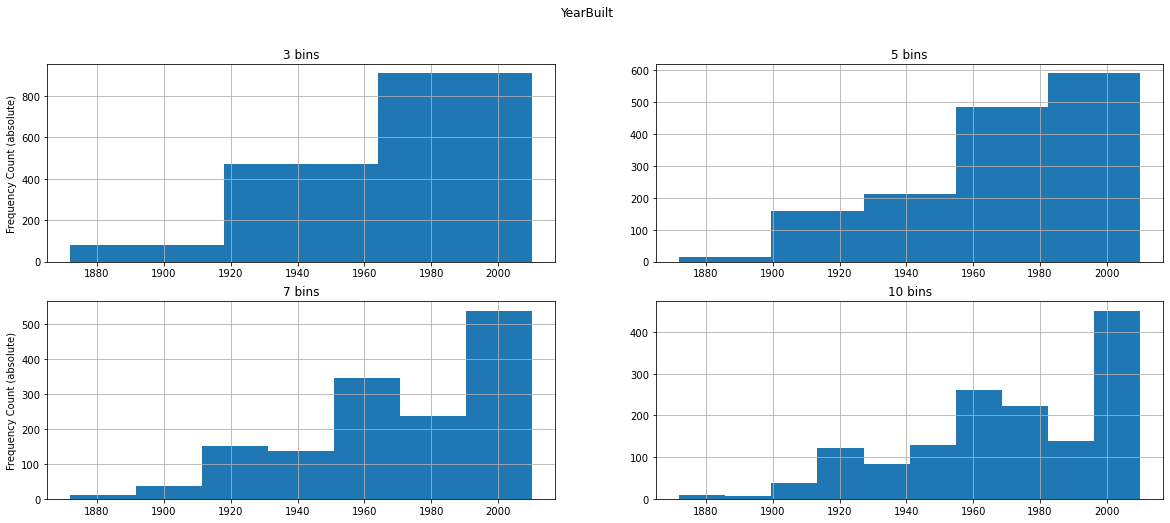

In [59]:
# Visualize different histograms of the 'YearBuilt' variable

plt.figure(figsize=(20, 8)).suptitle('YearBuilt')

plt.subplot(2, 2, 1)
plt.title('3 bins')
(_, bin_bounds_3, _) = plt.hist(df_iteration_2.YearBuilt, 3)
plt.ylabel('Frequency Count (absolute)')
plt.grid()

plt.subplot(2, 2, 2)
(_, bin_bounds_5, _) = plt.hist(df_iteration_2.YearBuilt, 5)
plt.title('5 bins')
plt.grid()

plt.subplot(2, 2, 3)
plt.title('7 bins')
(_, bin_bounds_7, _) = plt.hist(df_iteration_2.YearBuilt, 7)
plt.ylabel('Frequency Count (absolute)')
plt.grid()

plt.subplot(2, 2, 4)
plt.title('10 bins')
(_, bin_bounds_10, _) = plt.hist(df_iteration_2.YearBuilt, 10)
plt.grid()

plt.show()

In [60]:
# We will take some of the '7 bins' boundaries to create 6 custom bins

yearbuilt_bin_bounds = pd.IntervalIndex.from_tuples([
    (df_iteration_2.YearBuilt.min()-1, bin_bounds_7[2]),
    (bin_bounds_7[2], bin_bounds_7[3]),
    (bin_bounds_7[3], bin_bounds_7[4]),
    (bin_bounds_7[4], bin_bounds_7[5]),
    (bin_bounds_7[5], bin_bounds_7[6]),
    (bin_bounds_7[6], df_iteration_2.YearBuilt.max())])

df_yearbuilt_bin = pd.concat([df_iteration_2.YearBuilt, pd.cut(df_iteration_2.YearBuilt, yearbuilt_bin_bounds)], axis=1)
df_yearbuilt_bin.columns = ['YearBuilt', 'YearBuilt_bin_bound']
df_yearbuilt_bin.head()

,YearBuilt,YearBuilt_bin_bound
0,2003,"(1990.2857142857142, 2010.0]"
1,1976,"(1970.5714285714287, 1990.2857142857142]"
2,2001,"(1990.2857142857142, 2010.0]"
3,1915,"(1911.4285714285713, 1931.142857142857]"
4,2000,"(1990.2857142857142, 2010.0]"


In [61]:
# Replace each bin label by the bin median

for bin_bound in yearbuilt_bin_bounds:
    condition = (df_yearbuilt_bin.YearBuilt_bin_bound == bin_bound)
    df_yearbuilt_bin.loc[condition, 'YearBuilt_bin'] = df_yearbuilt_bin[condition].YearBuilt.median()

# The value for each bin is placed in the column 'YearBuilt_bin'    

df_yearbuilt_bin.head()

,YearBuilt,YearBuilt_bin_bound,YearBuilt_bin
0,2003,"(1990.2857142857142, 2010.0]",2004.0
1,1976,"(1970.5714285714287, 1990.2857142857142]",1977.0
2,2001,"(1990.2857142857142, 2010.0]",2004.0
3,1915,"(1911.4285714285713, 1931.142857142857]",1921.5
4,2000,"(1990.2857142857142, 2010.0]",2004.0


**'LotFrontage_encoded'**

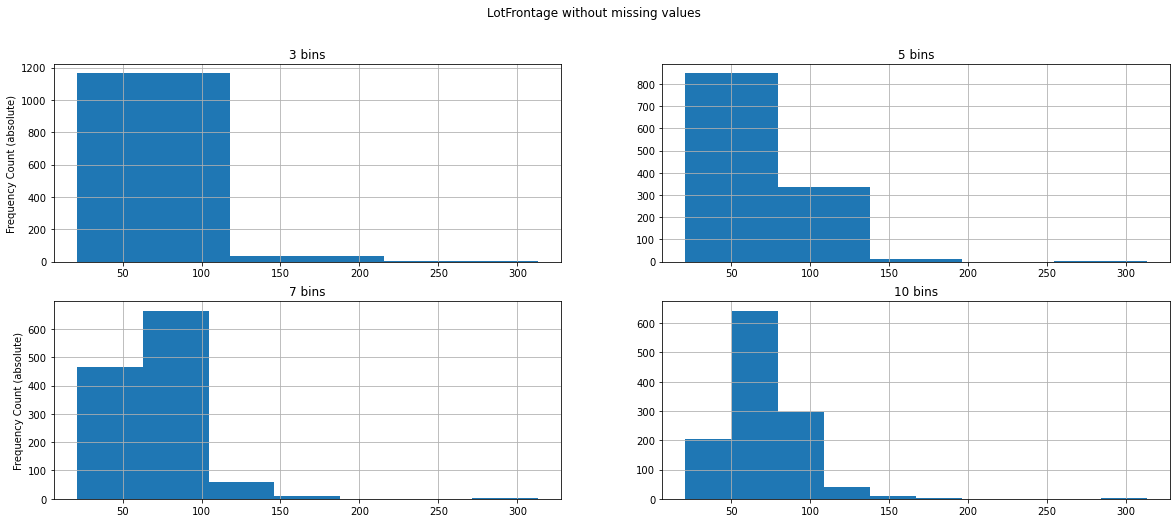

In [62]:
# Visualize different histograms of the 'LotFrontage_encoded' variable, excluding the missing value token

lotfrontage_filled = df_iteration_2.LotFrontage_encoded[df_iteration_2.LotFrontage_encoded > -1]

plt.figure(figsize=(20, 8)).suptitle('LotFrontage without missing values')

plt.subplot(2, 2, 1)
plt.title('3 bins')
(_, bin_bounds_3, _) = plt.hist(lotfrontage_filled, 3)
plt.ylabel('Frequency Count (absolute)')
plt.grid()

plt.subplot(2, 2, 2)
(_, bin_bounds_5, _) = plt.hist(lotfrontage_filled, 5)
plt.title('5 bins')
plt.grid()

plt.subplot(2, 2, 3)
plt.title('7 bins')
(_, bin_bounds_7, _) = plt.hist(lotfrontage_filled, 7)
plt.ylabel('Frequency Count (absolute)')
plt.grid()

plt.subplot(2, 2, 4)
plt.title('10 bins')
(_, bin_bounds_10, _) = plt.hist(lotfrontage_filled, 10)
plt.grid()

plt.show()

In [63]:
# We will take some of the '10 bins' boundaries, plus an exclusive boundary for missing values, and create 5 custom bins

lotfrontage_bin_bounds = pd.IntervalIndex.from_tuples([
    (df_iteration_2.LotFrontage_encoded.min()-1, df_iteration_2.LotFrontage_encoded.min()),
    (bin_bounds_10[0]-1, bin_bounds_10[1]),
    (bin_bounds_10[1], bin_bounds_10[2]),
    (bin_bounds_10[2], bin_bounds_10[3]),
    (bin_bounds_10[3], df_iteration_2.LotFrontage_encoded.max())])

df_lotfrontage_bin = pd.concat([df_iteration_2.LotFrontage_encoded, pd.cut(df_iteration_2.LotFrontage_encoded, lotfrontage_bin_bounds)], axis=1)
df_lotfrontage_bin.columns = ['LotFrontage_encoded', 'LotFrontage_encoded_bin_bound']
df_lotfrontage_bin.head()

,LotFrontage_encoded,LotFrontage_encoded_bin_bound
0,65.0,"(50.2, 79.4]"
1,80.0,"(79.4, 108.6]"
2,68.0,"(50.2, 79.4]"
3,60.0,"(50.2, 79.4]"
4,84.0,"(79.4, 108.6]"


In [64]:
# Replace each bin label by the bin median

for bin_bound in lotfrontage_bin_bounds:
    condition = (df_lotfrontage_bin.LotFrontage_encoded_bin_bound == bin_bound)
    df_lotfrontage_bin.loc[condition, 'LotFrontage_encoded_bin'] = df_lotfrontage_bin[condition].LotFrontage_encoded.median()

# The value of each is placed in the column 'LotFrontage_encoded_bin'    

df_lotfrontage_bin.head()

,LotFrontage_encoded,LotFrontage_encoded_bin_bound,LotFrontage_encoded_bin
0,65.0,"(50.2, 79.4]",65.0
1,80.0,"(79.4, 108.6]",86.0
2,68.0,"(50.2, 79.4]",65.0
3,60.0,"(50.2, 79.4]",65.0
4,84.0,"(79.4, 108.6]",86.0


#### F.2. Standardize 'GarageArea', instead of using 'GarageArea_scale'

In [65]:
df_garagearea_zscore = get_series_zscore_dataframe(df_houses.GarageArea, 'GarageArea_zscore')

#### F.3. Train + Evaluation

In [66]:
# Join the dataframe

df_iteration_3 = pd.concat(
    [df_iteration_2.drop(['YearBuilt', 'LotFrontage_encoded', 'GarageArea_scaled'], axis=1),
     df_yearbuilt_bin.YearBuilt_bin, df_lotfrontage_bin.LotFrontage_encoded_bin, df_garagearea_zscore.GarageArea_zscore], axis=1)
df_iteration_3.head(1)

,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,FullBath,GarageCars,YearBuilt_bin,LotFrontage_encoded_bin,GarageArea_zscore
0,False,0,1,0,0,2,2,2004.0,65.0,0.351


In [67]:
df_train_evaluation.loc['iteration_3'] = train_and_evaluation(X=df_iteration_3, y=target_saleprice)
df_train_evaluation

,accuracy_score
mandatory_features,0.678423
iteration_1,0.825726
iteration_2,0.825726
iteration_3,0.825726


Despite the efforts on binning and scaling features, the accuracy of the model remains with the same value.

### G. Iteration #4

#### G.1. Sets of unused optional features

The result of the several iterations has kept the same accuracy value. Because of this, we will exchange the selected optional features by the next sets of three features in the correlation ranking: first set with 'TotRmsAbvGrd', 'Fireplaces' and 'OpenPorchSF'; second set with 'WoodDeckSF', 'SaleType' OHE features and 'SaleCondition' OHE features.

In [68]:
# Mandatory features + 'TotRmsAbvGrd' + 'Fireplaces' + 'OpenPorchSF'

df_next_set_1 = pd.concat([df_mandatory, df_houses_optional.TotRmsAbvGrd, df_houses_optional.Fireplaces, df_houses_optional.OpenPorchSF], axis=1)
df_next_set_1.head(1)

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,TotRmsAbvGrd,Fireplaces,OpenPorchSF
0,2003,65.0,False,0,1,0,0,8,0,61


In [69]:
next_set_1_acc = train_and_evaluation(X=df_next_set_1, y=target_saleprice)
next_set_1_acc

0.7676348547717843

In [70]:
# Mandatory features + 'WoodDeckSF' + 'SaleType' OHE features + 'SaleCondition' OHE features

df_next_set_2 = pd.concat([df_mandatory, df_houses_optional.WoodDeckSF, df_categorical_ohe], axis=1)
df_next_set_2.head(1)

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,WoodDeckSF,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2003,65.0,False,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [71]:
next_set_2_acc = train_and_evaluation(X=df_next_set_2, y=target_saleprice)
next_set_2_acc

0.6970954356846473

#### G.2. Joining unused optional features with the most correlated

In [72]:
# Go through 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'WoodDeckSF', 'SaleType' OHE features and 'SaleCondition' OHE features
# Train and test the algorithm for each of them, joined with 

additional_features = [df_houses_optional.TotRmsAbvGrd, df_houses_optional.Fireplaces, df_houses_optional.OpenPorchSF,
                       df_houses_optional.WoodDeckSF, df_sale_type_ohe, df_sale_condition_ohe]

features_labels = ['TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'WoodDeckSF', 'SaleType OHE', 'SaleCondition OHE']
i = 0
list_add_features = []

for add_feature in additional_features:
    
    result = train_and_evaluation(
                        X=pd.concat([df_mandatory, df_houses_optional.FullBath, df_houses_optional.GarageCars, add_feature], axis=1),
                        y=target_saleprice)
    
    list_add_features.append(AdditionalFeature(features_labels[i], result))
    i += 1
    
# Sort the objects in the list by their accuracy
list_add_features_sorted = sorted(list_add_features, key=lambda x: x.accuracy, reverse=True)

for feature_acc in list_add_features_sorted:
    print(feature_acc)

OpenPorchSF: 0.8340248962655602
Fireplaces: 0.8298755186721992
TotRmsAbvGrd: 0.8278008298755186
WoodDeckSF: 0.8278008298755186
SaleType OHE: 0.8278008298755186
SaleCondition OHE: 0.8278008298755186


In [73]:
df_train_evaluation.loc['iteration_4'] = list_add_features_sorted[0].accuracy
df_train_evaluation

,accuracy_score
mandatory_features,0.678423
iteration_1,0.825726
iteration_2,0.825726
iteration_3,0.825726
iteration_4,0.834025


In [74]:
# Define the dataframe with the best accuracy in this iteration, for later use

df_iteration_4 = pd.concat(
    [df_mandatory, df_houses_optional.FullBath, df_houses_optional.GarageCars, df_houses_optional.OpenPorchSF], axis=1)
df_iteration_4.head(1)

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,FullBath,GarageCars,OpenPorchSF
0,2003,65.0,False,0,1,0,0,2,2,61


### H. Iteration #5

#### H.1. Normalization between [0; 1]

In [75]:
df_iteration_5_norm = get_dataframe_scaled(df_iteration_4)
df_iteration_5_norm.describe()

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,FullBath,GarageCars,OpenPorchSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.719332,0.186133,0.177397,0.010274,0.304795,0.591781,0.087671,0.521689,0.441781,0.085302
std,0.218862,0.111338,0.382135,0.100873,0.460478,0.491673,0.282913,0.183639,0.186829,0.121126
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.594203,0.136943,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.250000,0.000000
50%,0.731884,0.203822,0.000000,0.000000,0.000000,1.000000,0.000000,0.666667,0.500000,0.045704
75%,0.927536,0.254777,0.000000,0.000000,1.000000,1.000000,0.000000,0.666667,0.500000,0.124314
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### H.2. Z-Score standardization

In [76]:
df_iteration_5_standard = get_dataframe_zscore(df_iteration_4)
df_iteration_5_standard.describe()

,YearBuilt,LotFrontage_encoded,LotFrontage_is_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,FullBath,GarageCars,OpenPorchSF
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,1.032983e-15,8.562405e-17,-6.668942e-17,3.119651e-17,1.463061e-16,-1.350518e-16,-1.551271e-16,2.770995e-16,2.585451e-17,3.357284e-17
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-3.287824e+00,-1.672354e+00,-4.643852e-01,-1.018853e-01,-6.621357e-01,-1.204020e+00,-3.099937e-01,-2.841822e+00,-2.365440e+00,-7.044833e-01
25%,-5.719226e-01,-4.419644e-01,-4.643852e-01,-1.018853e-01,-6.621357e-01,-1.204020e+00,-3.099937e-01,-1.026041e+00,-1.026858e+00,-7.044833e-01
50%,5.737148e-02,1.589238e-01,-4.643852e-01,-1.018853e-01,-6.621357e-01,8.305509e-01,-3.099937e-01,7.897405e-01,3.117246e-01,-3.270298e-01
75%,9.516316e-01,6.167433e-01,-4.643852e-01,-1.018853e-01,1.510265e+00,8.305509e-01,-3.099937e-01,7.897405e-01,3.117246e-01,3.221901e-01
max,1.282839e+00,7.312354e+00,2.153385e+00,9.814955e+00,1.510265e+00,8.305509e-01,3.225872e+00,2.605522e+00,2.988889e+00,7.554198e+00


#### H.3. Train + Evaluation

In [77]:
print('Features normalized between [0; 1]:')
iter5_norm_acc = train_and_evaluation(X=df_iteration_5_norm, y=target_saleprice)
iter5_norm_acc

Features normalized between [0; 1]:


0.8402489626556017

In [78]:
print('Z-Score standardization:')
iter5_standard_acc = train_and_evaluation(X=df_iteration_5_standard, y=target_saleprice)
iter5_standard_acc

Z-Score standardization:


0.8506224066390041

In [79]:
df_train_evaluation.loc['iteration_5'] = iter5_standard_acc
df_train_evaluation

,accuracy_score
mandatory_features,0.678423
iteration_1,0.825726
iteration_2,0.825726
iteration_3,0.825726
iteration_4,0.834025
iteration_5,0.850622


### I. Iteration #6

#### I.1. Applying PCA

In [80]:
components, explained_variance_ratio = compute_pca(df_iteration_5_standard)

In [81]:
print('Principal Components:')
components.head()

Principal Components:


,0,1,2,3,4,5,6,7,8,9
0,1.970291,-0.183173,-1.204517,-0.320934,0.344944,-0.118668,-0.247746,-0.511382,-0.214697,-0.014960
1,-0.247145,1.027784,0.348070,-0.345024,0.055191,-1.282295,-0.288745,0.075416,0.120468,-0.007857
2,1.888631,-0.141562,-1.323978,-0.291776,0.173388,-0.288549,-0.295238,-0.438584,-0.146296,-0.013358
3,-1.228671,0.708449,0.145340,-0.024900,0.089597,-0.165144,1.256851,2.168790,-0.619765,0.009322
4,2.643478,0.276047,-1.021058,-0.385078,0.667052,-0.302661,0.515204,0.370509,-0.078458,-0.013644


In [82]:
print('Components Explained Variance Ratio:')
explained_variance_ratio

Components Explained Variance Ratio:


array([0.28408606, 0.18648479, 0.13111903, 0.10368328, 0.09505344,
       0.08014923, 0.05259941, 0.0457667 , 0.02006312, 0.00099494])

#### I.2. Train + Evaluation

In [83]:
print('All the components:')
iter6_all_components_acc = train_and_evaluation(X=components, y=target_saleprice)
iter6_all_components_acc

All the components:


0.8506224066390041

In [84]:
print('6 components with most explained variance:')
iter6_best_components_acc = train_and_evaluation(X=components.loc[:, 0:5], y=target_saleprice)
iter6_best_components_acc

6 components with most explained variance:


0.8443983402489627

In [85]:
# Assign the best result to our results history

df_train_evaluation.loc['iteration_6'] = iter6_all_components_acc
df_train_evaluation

,accuracy_score
mandatory_features,0.678423
iteration_1,0.825726
iteration_2,0.825726
iteration_3,0.825726
iteration_4,0.834025
iteration_5,0.850622
iteration_6,0.850622
